In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df=pd.read_csv('VOF.L.csv',index_col='Date',parse_dates=True, usecols=[0,4])

print('Shape of data',df.shape)
df.head()

Shape of data (1262, 1)


,Close
Date,
2017-12-28,326.00
2017-12-29,331.75
2018-01-02,342.00
2018-01-03,352.00
2018-01-04,350.00


<AxesSubplot:xlabel='Date'>

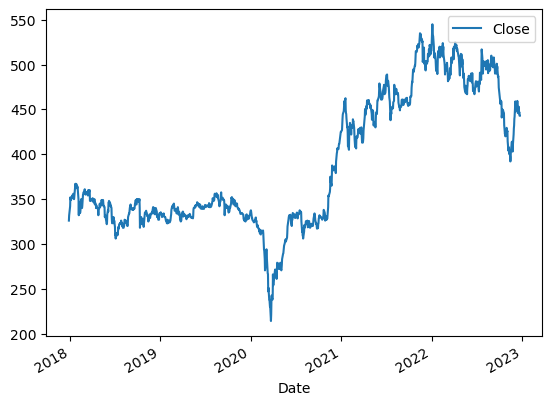

In [3]:
df.plot()

In [4]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df['Close'])
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  0.6677551271486659  if above 0.05, data is not stationary


In [5]:
train_length = int(len(df)*0.8)
train_length

1009

In [6]:
print(df.shape)
train=df.iloc[:train_length]
test=df.iloc[train_length:]
print(train.shape,test.shape)

(1262, 1)
(1009, 1) (253, 1)


In [7]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['Close'], start_p = 1, d=1, start_q = 1,
                          max_p = 5, max_q = 5, max_d=5, m = 12,
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = False,
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True, n_fits=50)

# To print the summary
print(arima_model.summary() ) #Note down the Model and details.

C:\Users\Priest\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7655.712, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7652.865, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7653.965, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7653.977, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7651.296, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.033 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1262
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3824.648
Date:                Sun, 01 Jan 2023   AIC                           7651.296
Time:                        22:30:02   BIC                           7656.435
Sample:                             0   HQIC                          7653.227
                               - 1262                                       

In [8]:
# Fit a SARIMAX(0, 1, 0) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
                order = (0, 1, 0),
                seasonal_order =(0, 0, 0, 0))

result = model.fit()
result.summary()

C:\Users\Priest\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Priest\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1009
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2936.164
Date:                Sun, 01 Jan 2023   AIC                           5874.328
Time:                        22:30:02   BIC                           5879.244
Sample:                             0   HQIC                          5876.196
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        19.8428      0.467     42.491      0.000      18.928      20.758
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):              1151.86
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
#Train prediction
start_index = 0
end_index = len(train)-1
train_prediction = result.predict(start_index, end_index)

In [10]:
#Prediction
start_index = len(train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted Close')
prediction.index=test.index

C:\Users\Priest\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [11]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 11.19 RMSE
Test Score: 47.47 RMSE


In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
print('Test r2 score:', r2_score(test, prediction))
print('Test mean absolute error:', mean_absolute_error(test, prediction))
print('Test mean absolute percentage error:', mean_absolute_percentage_error(test, prediction))

Test r2 score: -1.1769541599990023
Test mean absolute error: 35.93873517786561
Test mean absolute percentage error: 0.079510210568706


<AxesSubplot:xlabel='Date'>

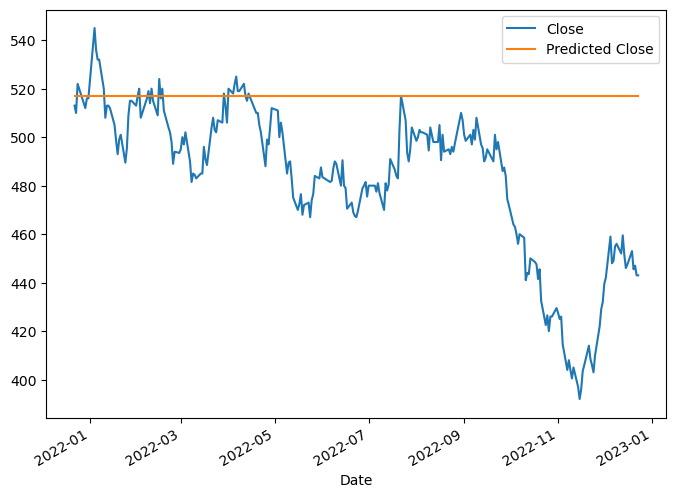

In [13]:
# plot predictions and actual values
test['Close'].plot(legend = True, figsize=(8,6))
prediction.plot(legend = True, figsize=(8,6))

<AxesSubplot:xlabel='Date'>

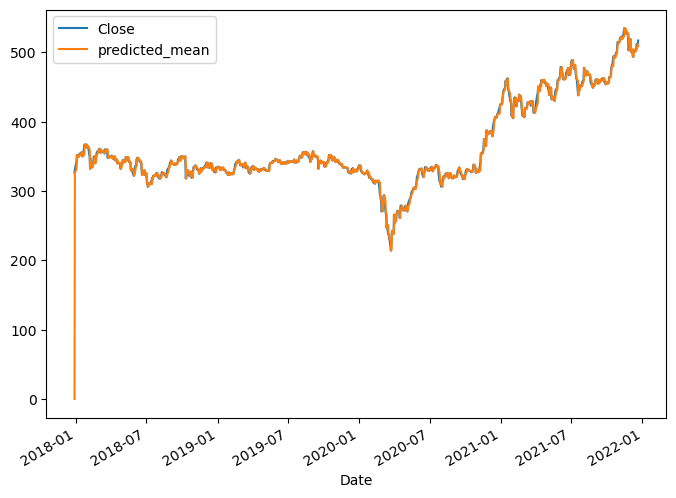

In [14]:
train['Close'].plot(legend = True, figsize=(8,6))
train_prediction.plot(legend = True, figsize=(8,6))

<AxesSubplot:xlabel='Date'>

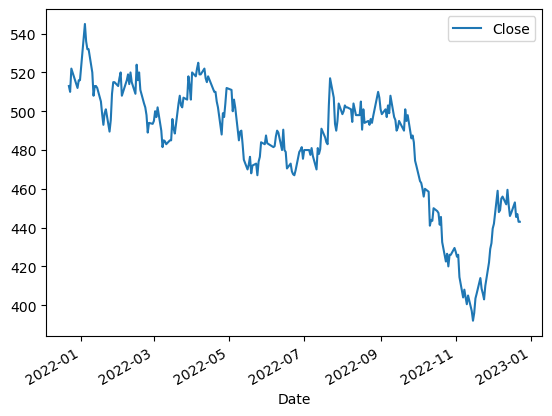

In [15]:
test.plot()

In [16]:
prediction.to_csv('D:\Workspace\Python\Final\Arima20.csv')

OSError: Cannot save file into a non-existent directory: 'D:\Workspace\Python\Final'

In [ ]:
prediction.plot()

Forecast

In [ ]:
start_index = len(df)
end_index = len(df)+29
forecast = result.predict(start_index, end_index).rename('Predicted Close')

In [ ]:
forecast

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(forecast, label='ARIMA Forecast')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
df2 = pd.read_csv('VOF.L.csv', usecols=[4])

In [ ]:
df2.plot(figsize=(20,10))
forecast.plot(figsize=(20,10))